## Chapter 07. MonteCarlo-TreeSearch TicTacToe-
---
- 목표: MCTS를 이용해 'TicTacToe' 문제를 해결

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import sys
sys.path.append('../material/')

#from TicTacToe import TicTacToe
from TicTacToe_gym import TicTacToeEnv
from gym.core import Wrapper
from pickle import dumps, loads
from collections import namedtuple
from IPython.display import clear_output
from itertools import count
from tqdm import trange
import copy

%matplotlib inline

In [2]:
# a container for get_result function below. Works just like tuple, but prettier
ActionResult = namedtuple(
    "action_result", ("snapshot", "observation", "reward", "is_done", "info"))


class WithSnapshots_TicTacToe(Wrapper):
    """
    Creates a wrapper that supports saving and loading environemnt states.
    Required for planning algorithms.

    This class will have access to the core environment as self.env, e.g.:
    - self.env.reset()           #reset original env
    - self.env.ale.cloneState()  #make snapshot for atari. load with .restoreState()
    - ...

    You can also use reset() and step() directly for convenience.
    - s = self.reset()                   # same as self.env.reset()
    - s, r, done, _ = self.step(action)  # same as self.env.step(action)
    
    Note that while you may use self.render(), it will spawn a window that cannot be pickled.
    Thus, you will need to call self.close() before pickling will work again.
    """
    #def __init__(self):
    #    super(WithSnapshots_TicTacToe,self).__init__()
    
    def get_snapshot(self, render=False):
        """
        :returns: environment state that can be loaded with load_snapshot 
        Snapshots guarantee same env behaviour each time they are loaded.

        Warning! Snapshots can be arbitrary things (strings, integers, json, tuples)
        Don't count on them being pickle strings when implementing MCTS.

        Developer Note: Make sure the object you return will not be affected by 
        anything that happens to the environment after it's saved.
        You shouldn't, for example, return self.env. 
        In case of doubt, use pickle.dumps or deepcopy.

        """
        if render:
            self.render()  # close popup windows since we can't pickle them
            self.close()
            
        #if self.unwrapped.viewer is not None:
        #    self.unwrapped.viewer.close()
        #    self.unwrapped.viewer = None
        return dumps(self.env)
        #return dumps(TicTacToe)

    def load_snapshot(self, snapshot, render=False):
        """
        Loads snapshot as current env state.
        Should not change snapshot inplace (in case of doubt, deepcopy).
        """

        assert not hasattr(self, "_monitor") or hasattr(
            self.env, "_monitor"), "can't backtrack while recording"

        if render:
            self.render()  # close popup windows since we can't load into them
            self.close()
        self.env = loads(snapshot)

    def get_result(self, snapshot, action):
        """
        A convenience function that 
        - loads snapshot, 
        - commits action via self.step,
        - and takes snapshot again :)

        :returns: next snapshot, next_observation, reward, is_done, info

        Basically it returns next snapshot and everything that env.step would have returned.
        """

        #<YOUR CODE: load, commit, take snapshot>
        self.load_snapshot(snapshot)
        new_state, reward, done, info = self.env.step(action)
        next_snapshot = self.get_snapshot()
        return ActionResult(
            next_snapshot, 
            new_state, 
            reward, 
            done, 
            info,
        )

In [3]:
import gym
from gym.core import Wrapper
from pickle import dumps, loads
from collections import namedtuple

# a container for get_result function below. Works just like tuple, but prettier
ActionResult = namedtuple(
    "action_result", ("snapshot", "observation", "reward", "is_done", "info"))


class WithSnapshots(Wrapper):
    """
    Creates a wrapper that supports saving and loading environemnt states.
    Required for planning algorithms.

    This class will have access to the core environment as self.env, e.g.:
    - self.env.reset()           #reset original env
    - self.env.ale.cloneState()  #make snapshot for atari. load with .restoreState()
    - ...

    You can also use reset() and step() directly for convenience.
    - s = self.reset()                   # same as self.env.reset()
    - s, r, done, _ = self.step(action)  # same as self.env.step(action)
    
    Note that while you may use self.render(), it will spawn a window that cannot be pickled.
    Thus, you will need to call self.close() before pickling will work again.
    """

    def get_snapshot(self, render=False):
        """
        :returns: environment state that can be loaded with load_snapshot 
        Snapshots guarantee same env behaviour each time they are loaded.

        Warning! Snapshots can be arbitrary things (strings, integers, json, tuples)
        Don't count on them being pickle strings when implementing MCTS.

        Developer Note: Make sure the object you return will not be affected by 
        anything that happens to the environment after it's saved.
        You shouldn't, for example, return self.env. 
        In case of doubt, use pickle.dumps or deepcopy.

        """
        if render:
            self.render()  # close popup windows since we can't pickle them
            self.close()
            
        #if self.unwrapped.viewer is not None:
        #    self.unwrapped.viewer.close()
        #    self.unwrapped.viewer = None
        return dumps(self.env)

    def load_snapshot(self, snapshot, render=False):
        """
        Loads snapshot as current env state.
        Should not change snapshot inplace (in case of doubt, deepcopy).
        """

        assert not hasattr(self, "_monitor") or hasattr(
            self.env, "_monitor"), "can't backtrack while recording"

        if render:
            self.render()  # close popup windows since we can't load into them
            self.close()

        self.env  = loads(snapshot)

    def get_result(self, snapshot, action):
        """
        A convenience function that 
        - loads snapshot, 
        - commits action via self.step,
        - and takes snapshot again :)

        :returns: next snapshot, next_observation, reward, is_done, info

        Basically it returns next snapshot and everything that env.step would have returned.
        """

        #<YOUR CODE: load, commit, take snapshot>
        self.load_snapshot(snapshot)
        new_state, reward, done, info = self.env.step(action)
        next_snapshot = self.get_snapshot()
        return ActionResult(
            next_snapshot, 
            new_state, 
            reward, 
            done, 
            info,
        )

In [4]:
env = WithSnapshots(TicTacToeEnv())
env.reset()

actions = env.valid_action()
print("initial_state:")
env.render()

initial_state:
   |   |
   |   |  
   |   |
-----------
   |   |
   |   |  
   |   |
-----------
   |   |
   |   |  
   |   |


In [5]:
actions = env.valid_action()
print(actions)

[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [6]:
env.step(5)
env.render()

   |   |
   |   | O
   |   |
-----------
   |   |
   | X |  
   |   |
-----------
   |   |
   |   |  
   |   |


In [7]:
actions = env.valid_action()
print(actions)

[1, 2, 3, 4, 6, 7, 8]


In [8]:
env.step(6)
env.render()

   |   |
 O |   | O
   |   |
-----------
   |   |
   | X | X
   |   |
-----------
   |   |
   |   |  
   |   |


In [9]:
env.step(1)
env.render()

   |   |
 O | O | O
   |   |
-----------
   |   |
   | X | X
   |   |
-----------
   |   |
 X |   |  
   |   |


In [10]:
env.step(3)
env.reward

-1

# Node class definition

In [11]:
class Node():
    parent = None  
    qvalue_sum = 0.  
    times_visited = 0  
    U = 1e100
    def __init__(self, parent, action):
        self.parent = parent
        self.action = action
        self.children = set()
        #self.observation = observation
        #self.observation = self.parent.Observation # Hyunseok added
        
        res = env.get_result(parent.snapshot, action)
        #res = env.get_result(parent.snapshot, observation, action) # Hyunseok added
        self.snapshot, self.observation, self.immediate_reward, self.is_done, _ = res

    def is_leaf(self):
        return len(self.children) == 0

    def is_root(self):
        return self.parent is None

    def get_qvalue_estimate(self):
        return self.qvalue_sum / self.times_visited if self.times_visited != 0 else 0

    def ucb_score(self, scale=10, max_value=1e100):
        if self.times_visited == 0:
            return self.U

        self.U = np.sqrt(np.log(self.parent.times_visited)/self.times_visited)
        return self.get_qvalue_estimate() + scale * self.U

    def select_best_leaf(self,monitoring=False):
        if self.is_leaf():
            return self

        children = self.children
        best_child = max([(child.ucb_score(),child) for child in children], key=lambda x: x[0])[1]
        return best_child.select_best_leaf()

    def expand(self):
        if self.is_done:
            raise ValueError("종료시점에서는 더 이상 확장할 필요가 없습니다")
            
        env.load_snapshot(self.snapshot)
        #env.load_snapshot(self.snapshot,self.observation) # Hyunseok addede
        valid_actions = env.valid_action()
        for action in valid_actions:
            self.children.add(Node(self,action))
        return self.select_best_leaf()

    def simulation(self,tmax=10):
        env.load_snapshot(self.snapshot)
        #obs = self.observation
        is_done = self.is_done

        if is_done:
            simulation_reward = 0
        else:
            simulation_reward = 0
            while tmax >= 0:
                tmax -= 1
                valid_actions = env.valid_action()
                #print(valid_actions)
                next_obs,reward,done,info = env.step(np.random.choice(valid_actions))
                #next_obs,reward,done,info=env.step(env.action_space.sample())
                simulation_reward += reward
                if done:
                    break
        return simulation_reward

    def propagate(self, child_qvalue, gamma=0.99):
        my_qvalue = self.immediate_reward + gamma*child_qvalue

        self.qvalue_sum += my_qvalue
        self.times_visited += 1

        # propagate upwards
        if not self.is_root():
            self.parent.propagate(my_qvalue)

    def safe_delete(self):
        """safe delete to prevent memory leak in some python versions"""
        #del self.parent
        for child in self.children:
            child.safe_delete()
            del child

In [12]:
class Root(Node):
    def __init__(self, snapshot, observation):
        #super(Root,self).__init__(snapshot,observation)
        """
        creates special node that acts like tree root
        :snapshot: snapshot (from env.get_snapshot) to start planning from
        :observation: last environment observation
        """
        self.parent = self.action = None
        self.children = set()  # set of child nodes

        self.snapshot = snapshot
        self.observation = observation
        self.immediate_reward = 0
        self.is_done = False
        
    @staticmethod
    def from_node(node):
        """initializes node as root"""
        root = Root(node.snapshot, node.observation)
        # copy data
        copied_fields = ["qvalue_sum", "times_visited", "children", "is_done", "U"]
        for field in copied_fields:
            setattr(root, field, getattr(node, field))
        return root

In [13]:
def plan_mcts(root, n_iters=10):
    """
    builds tree with monte-carlo tree search for n_iters iterations
    :param root: tree node to plan from
    :param n_iters: how many select-expand-simulate-propagete loops to make
    """
    #for _ in range(n_iters):
    for _ in trange(n_iters):
        #<YOUR CODE: select best leaf>
        node = root.select_best_leaf()

        if node.is_done:
            # All rollouts from a terminal node are empty, and thus have 0 reward.
            node.propagate(0)
        else:
            # Expand the best leaf. Perform a rollout from it. Propagate the results upwards.
            # Note that here you have some leeway in choosing where to propagate from.
            # Any reasonable choice should work.
            
            #<YOUR CODE>
            node_child = node.expand()
            child_reward = node_child.simulation()
            node.propagate(child_reward)

In [14]:
# Easy mode
env = WithSnapshots(TicTacToeEnv())

root_observation = env.reset()
root_snapshot = env.get_snapshot()
root = Root(root_snapshot, root_observation)

In [15]:
plan_mcts(root, n_iters=int(4e+06))
root_backup = copy.deepcopy(root)

100%|██████████████████████████████████████████████████████████████| 4000000/4000000 [04:31<00:00, 14718.81it/s]


In [89]:
import time

total_reward = 0  # sum of rewards
test_env = loads(root_snapshot)  # env used to show progress
root = copy.deepcopy(root_backup)

Best_Q, Best_UCB, Best_visited = [],[],[]
for i in count():
    # get best child
    #<YOUR CODE: select child with the highest mean reward>
    best_child = max([(child.get_qvalue_estimate(),child) for child in root.children], key=lambda x: x[0])[1]

    # take action
    s, r, done, _ = test_env.step(best_child.action)

    # show image
    clear_output(True)
    #print("현재 노드 정보")
    #print(f'Q: {root.get_qvalue_estimate()}, UCB: {root.U}, Time_visited: {root.times_visited}')
    Best_Q.append(root.get_qvalue_estimate())
    Best_UCB.append(root.U)
    Best_visited.append(root.times_visited)
    
    time.sleep(1)
    print(f'Step {i}')
    #root.render()
    test_env.render()
    
    total_reward += r
    if done:
        print("최종보상 = ", total_reward) 
        break

    # discard unrealized part of the tree [because not every child matters :(]
    for child in root.children:
        if child != best_child:
            child.safe_delete()

    # declare best child a new root
    root = Root.from_node(best_child)

    assert not root.is_leaf(), \
        "We ran out of tree! Need more planning! Try growing the tree right inside the loop."

Step 3
   |   |
 O | X | O
   |   |
-----------
   |   |
 O |   | O
   |   |
-----------
   |   |
 X | X | X
   |   |


AssertionError: 

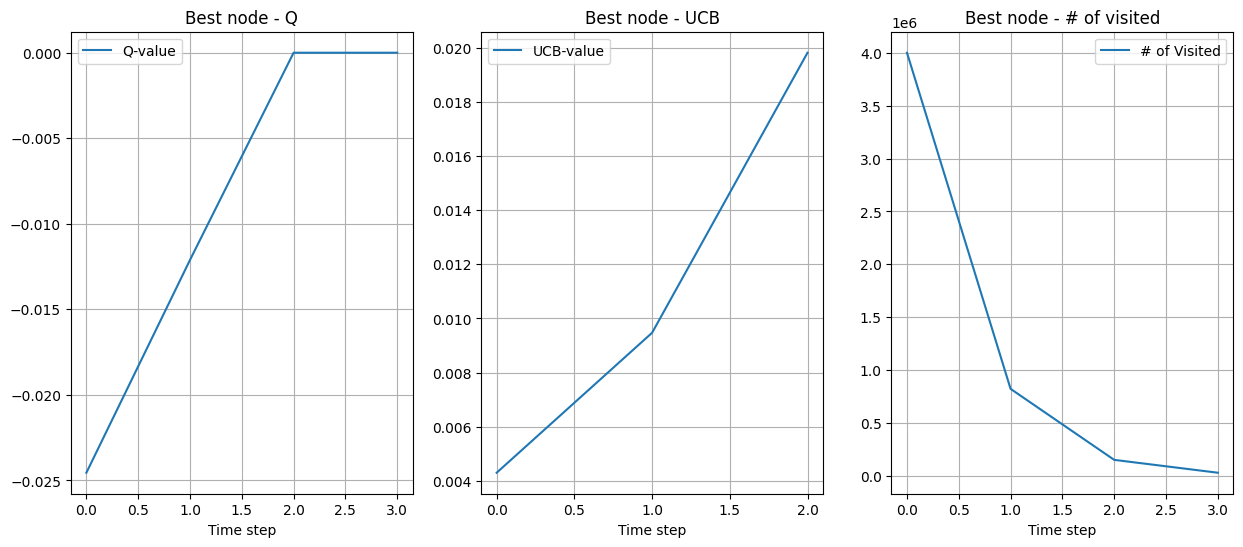

In [90]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.plot(Best_Q,label='Q-value')
plt.xlabel('Time step')
plt.title('Best node - Q')
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(Best_UCB[1:],label='UCB-value')
plt.xlabel('Time step')
plt.title('Best node - UCB')
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(Best_visited,label='# of Visited')
plt.xlabel('Time step')
plt.title('Best node - # of visited')
plt.legend()
plt.grid()

In [91]:
 Best_UCB

[1e+100, 0.004297955401302996, 0.009469656816148081, 0.01981820780717615]

In [19]:
env = WithSnapshots(TicTacToeEnv())

In [20]:
env.reset()

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

In [21]:
env.valid_action()

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [22]:
env.render()

   |   |
   |   |  
   |   |
-----------
   |   |
   |   |  
   |   |
-----------
   |   |
   |   |  
   |   |


In [23]:
env.step(5)
env.render()

   |   |
   |   | O
   |   |
-----------
   |   |
   | X |  
   |   |
-----------
   |   |
   |   |  
   |   |


In [24]:
env.step(2)
env.render()

   |   |
 O |   | O
   |   |
-----------
   |   |
   | X |  
   |   |
-----------
   |   |
   | X |  
   |   |


In [25]:
env.step(8)
env.render()

   |   |
 O | X | O
   |   |
-----------
   |   |
   | X |  
   |   |
-----------
   |   |
 O | X |  
   |   |


In [26]:
env.info

{'Round': 6, 'Player': 'O', 'Winner': None}

In [27]:
obs,_,_,_ = env.step(9)

AssertionError: 

In [ ]:
obs

In [ ]:
env.reset()

In [ ]:
env.step(1)

In [ ]:
env.reset()
env.valid_action()

In [ ]:
env.step(1)

In [ ]:
env.step(5)
env.render()

In [ ]:
env.step(8)
env.render()

In [ ]:
env.step(6)
env.render()

In [ ]:
env.step(4)

In [ ]:
env.reset()

In [ ]:
env.step(1)
env.render()

In [ ]:
env.step(5)
env.render()

In [ ]:
env.step(6)
env.render()

In [ ]:
env.step(8)
env.render()

In [ ]:
env.step(2)
env.render()

In [ ]:
env.reset()
env.step(1)
env.render()

In [ ]:
env.step(5)
env.render()

In [ ]:
env.step(8)
env.render()

In [ ]:
env.step(6)

In [ ]:
env.render()

In [ ]:
env.step(4)

In [ ]:
env.render()

In [ ]:
env = TicTacToeEnv()
obs = env.reset()
env.render()

In [ ]:
env.valid_action()

In [ ]:
obs, reward, done, info = env.step(3)
print(f'정보: {info}')
print(f'가능한 액션: {env.valid_action()}')
env.render()

In [ ]:
env.step(5)
env.render()

In [ ]:
env.step(4)
env.render()

In [71]:
env.reset()

[' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']

In [72]:
env.step(3)
env.render()

   |   |
 O |   |  
   |   |
-----------
   |   |
   |   |  
   |   |
-----------
   |   |
   |   | X
   |   |


In [73]:
env.step(5)

([' ', ' ', 'O', 'X', ' ', 'X', ' ', 'O', ' ', ' '],
 0,
 False,
 {'Round': 4, 'Player': 'O', 'Winner': None})

In [74]:
env.render()

   |   |
 O |   |  
   |   |
-----------
   |   |
   | X |  
   |   |
-----------
   |   |
   | O | X
   |   |


In [75]:
env.step(6)

([' ', ' ', 'O', 'X', ' ', 'X', 'X', 'O', ' ', 'O'],
 0,
 False,
 {'Round': 6, 'Player': 'O', 'Winner': None})

In [76]:
env.render()

   |   |
 O |   | O
   |   |
-----------
   |   |
   | X | X
   |   |
-----------
   |   |
   | O | X
   |   |


In [77]:
env.step(8)
env.render()

   |   |
 O | X | O
   |   |
-----------
   |   |
 O | X | X
   |   |
-----------
   |   |
   | O | X
   |   |


In [78]:
env.step(1)

([' ', 'X', 'O', 'X', 'O', 'X', 'X', 'O', 'X', 'O'],
 0,
 True,
 {'Round': 9, 'Player': 'X', 'Winner': None})

In [79]:
env.render()

   |   |
 O | X | O
   |   |
-----------
   |   |
 O | X | X
   |   |
-----------
   |   |
 X | O | X
   |   |


In [81]:
print(f'정보: {env.info}')
print(f'가능한 액션: {env.valid_action()}')

정보: {'Round': 9, 'Player': 'X', 'Winner': None}
가능한 액션: []
